In [61]:
import sqlite3
import pandas as pd
import numpy as np
import geopandas as gpd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dot_density_mapping import gen_points_in_gdf_polys, gen_random_points_poly

import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [62]:
# read in geodata
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)

In [63]:
def compile_single_msoa_traveltimes(direction, target_msoa, ttm, msoa_boundaries = msoas):
    '''Compiles a geodataframe of travel times to or from a target msoa.
    target_msoa is an MSOA ID, direction is "from" or "to", ttm is a travel time matrix containing at least "orig_id" and 
    "dest_id", msoa_boundaries is a geodataframe of MSOA boundaries with MSOA IDs as index.'''
    if direction == 'to':
        output = ttm[ttm['dest_id'] == target_msoa]
        output.set_index('orig_id', inplace = True)
    elif direction == 'from':
        output = ttm[ttm['orig_id'] == target_msoa]
        output.set_index('dest_id', inplace = True)
    output = msoa_boundaries.join(output)
    return output

In [64]:
def calculate_provision_ratios(users, targets, ttm, traveltime_cutoff):
    '''Allocates target amenities to users among n areas using a modified cumulative accessibility measure that accounts 
    for competition effects.
    users is a n x 1 dataframe of the number of users per area for a particular amenity, targets is a n x 1 dataframe of 
    the number of target amenities per area, ttm is a n origins x n destinations travel time matrix, traveltime_cutoff is 
    the maximum travel time (inclusive) for a destination to be considered accessible from an origin.'''
    # ensure ttm, users and targets are sorted in the same order
    provision_ratios = users.loc[ttm.index,:].join(targets.loc[ttm.index,:])
    # calculate for each area, how many clients can reach it - note need to transpose the TTM to summarise to destinations instead of origins
    provision_ratios['Users Who Can Access'] = (ttm.transpose() <= traveltime_cutoff).dot(provision_ratios.iloc[:,0])
    # then divide the number of targets in each area evenly among all users who can reach it
    provision_ratios['Targets per User Who Can Access'] = provision_ratios.iloc[:,1] / provision_ratios['Users Who Can Access']
    # then sum up the number of targets per client who can reach each area to each origin
    provision_ratios['Targets within ' + str(traveltime_cutoff) + 'min per User'] = (ttm <= traveltime_cutoff).dot(provision_ratios['Targets per User Who Can Access'])
    # checking that all jobs have been allocated exactly once to reachable workers
    provision_ratios['Targets Allocated to Users'] = provision_ratios['Targets within ' + str(traveltime_cutoff) + 'min per User'] * provision_ratios.iloc[:,0]
    print('All targets allocated exactly once to reachable users:', np.sum(provision_ratios['Targets Allocated to Users']) == np.sum(targets))
    
    return provision_ratios

In [65]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

In [66]:
traveltime_cutoff = 45 # cutoff for considering which MSOAs are accessible from each MSOA

### Fig XX: Travel Times to/from Stratford

In [67]:
# read in minimum ampeak travel time data
db = sqlite3.connect('../../../../../data/London/TfL/TfL API/Travel Options/20190322_0830/traveloptions.db')
baseline_fastestoption_ampeak = pd.read_sql("SELECT orig_id, dest_id, option_id, fare, MIN(traveltime) FROM traveloptions WHERE legs_cycle == 0 GROUP BY orig_id, dest_id", db)
db.close()

In [68]:
np.sum(baseline_fastestoption_ampeak[baseline_fastestoption_ampeak['fare'] > 800]['MIN(traveltime)'] < 45)

16

In [69]:
with open('../90 Data/compiled secondary data/jobcounts', 'rb') as infile:
    jobcounts = pickle.load(infile)
jobcounts = jobcounts.loc[msoas.index,:] # soet the jobcounts according to MSOA ID

In [70]:
# compile travel times from Stratford and job counts
baseline_fastestoption_ampeak_from_stratford = compile_single_msoa_traveltimes('from', 'E02000726', baseline_fastestoption_ampeak)
baseline_fastestoption_ampeak_from_stratford = baseline_fastestoption_ampeak_from_stratford.join(jobcounts[['Jobs_Total']])

# generate dot density map for jobs
count_per_point = 2000
jobpoints = gpd.GeoDataFrame(gen_points_in_gdf_polys(msoas.geometry, baseline_fastestoption_ampeak_from_stratford['Jobs_Total'], points_per_value = count_per_point))

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

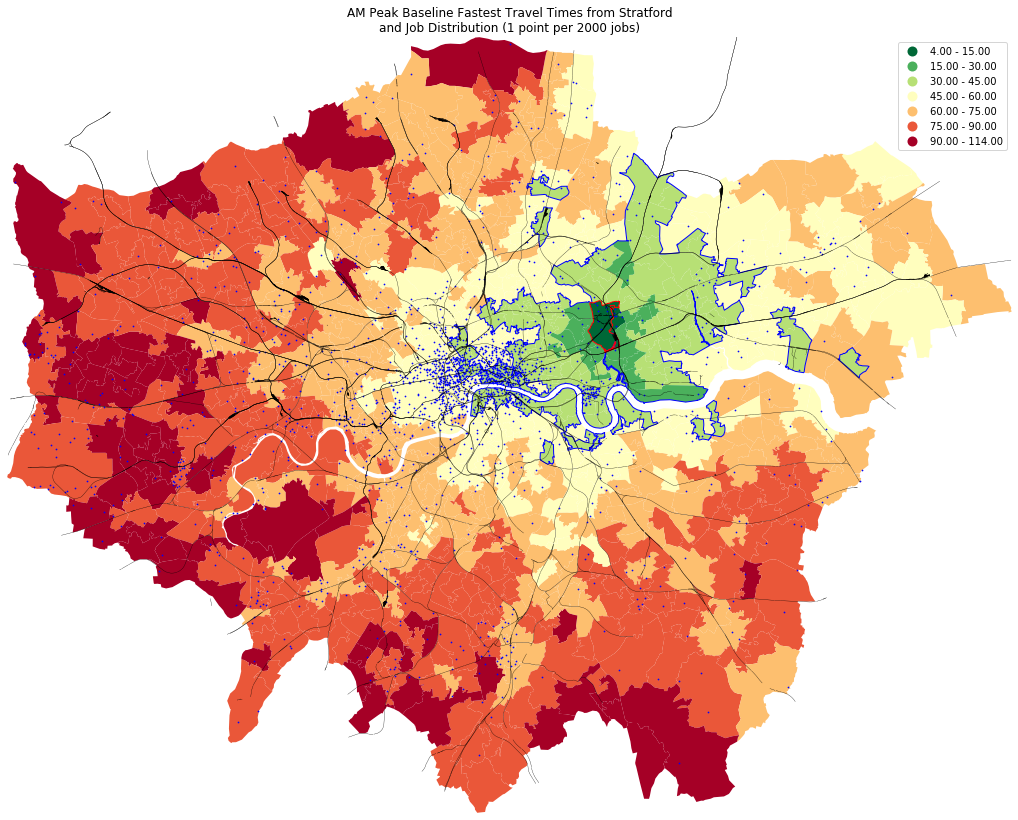

In [71]:
# plot figures
fig02 = plt.figure(figsize = (18,16))
ax02_01 = fig02.add_subplot(1,1,1)
set_zoom(ax02_01, msoas)
baseline_fastestoption_ampeak_from_stratford.plot(column = 'MIN(traveltime)', ax = ax02_01, scheme = 'userdefined', legend = True,
                                                  classification_kwds = {'bins':[15,30,45,60,75,90]}, cmap = 'RdYlGn_r') # travel times
baseline_fastestoption_ampeak_from_stratford[baseline_fastestoption_ampeak_from_stratford['MIN(traveltime)'] <= traveltime_cutoff].dissolve(by = 'orig_id').buffer(1).plot(color = 'None', edgecolor = 'blue', ax = ax02_01)
jobpoints.plot(color = 'blue', ax = ax02_01, markersize = .5) # dot density of jobs
londontube.plot(color = 'black', ax = ax02_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax02_01, linewidth = .3)
baseline_fastestoption_ampeak_from_stratford.loc[['E02000726'],:].plot(facecolor = 'none', edgecolor = 'red', ax = ax02_01) # location of Stratford
plt.title('AM Peak Baseline Fastest Travel Times from Stratford\nand Job Distribution (1 point per ' + str(count_per_point) + ' jobs)')
plt.axis('off')

### Fig XX: Job Provision Ratios

In [72]:
with open('../90 Data/compiled secondary data/popcounts', 'rb') as infile:
    popcounts = pickle.load(infile)
popcounts = popcounts.loc[msoas.index,:] # sort popcounts by MSOA IDs

In [73]:
## convert long-form travel time matrix to wide-form
ttm_baseline_ampeak = baseline_fastestoption_ampeak.pivot_table(index = 'orig_id', columns = 'dest_id', values = 'MIN(traveltime)')
jpr_ampeak_baseline = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts[['Jobs_Total']], ttm_baseline_ampeak, traveltime_cutoff)
jpr_ampeak_baseline = msoas.join(jpr_ampeak_baseline)

All targets allocated exactly once to reachable users: Jobs_Total    True
dtype: bool


In [74]:
# generate dot density map for working-age pop
count_per_point = 2000
poppoints = gpd.GeoDataFrame(gen_points_in_gdf_polys(msoas.geometry, jpr_ampeak_baseline['Pop_WorkingAge'], points_per_value = count_per_point))

Mean Jobs per Working Age Pop: 0.8821806962900559


Text(0.5, 1.0, 'Lorenz Curve of Jobs Allocated to\nPotential Workers')

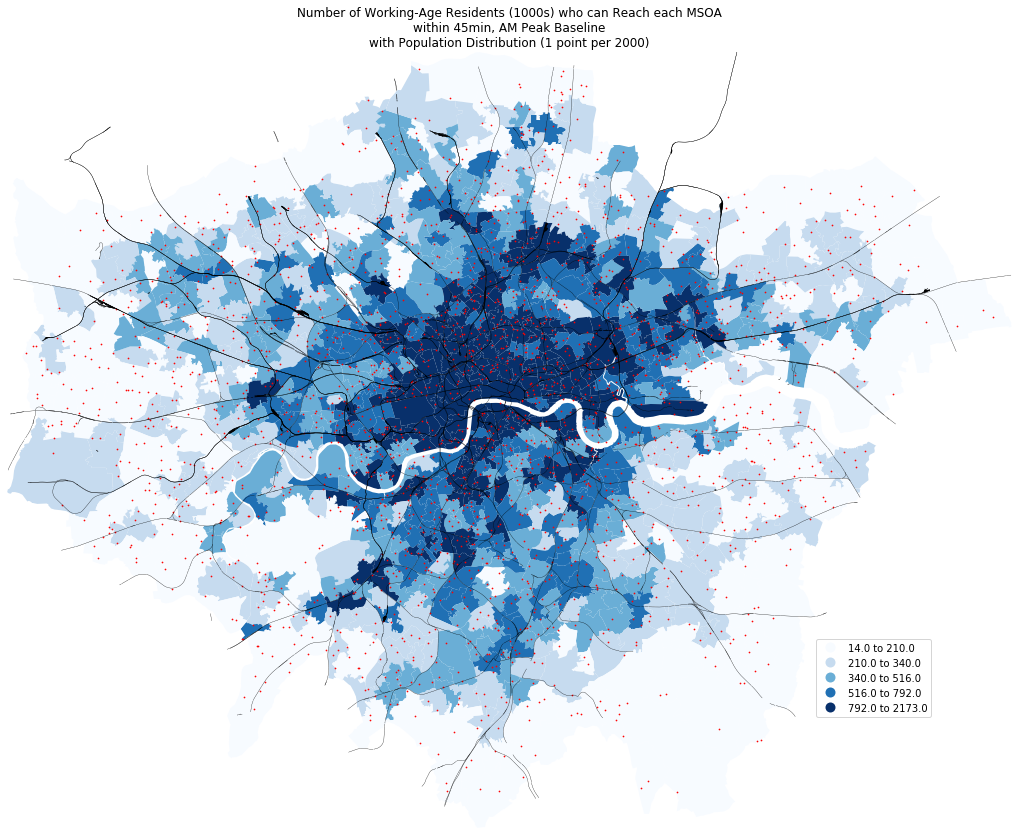

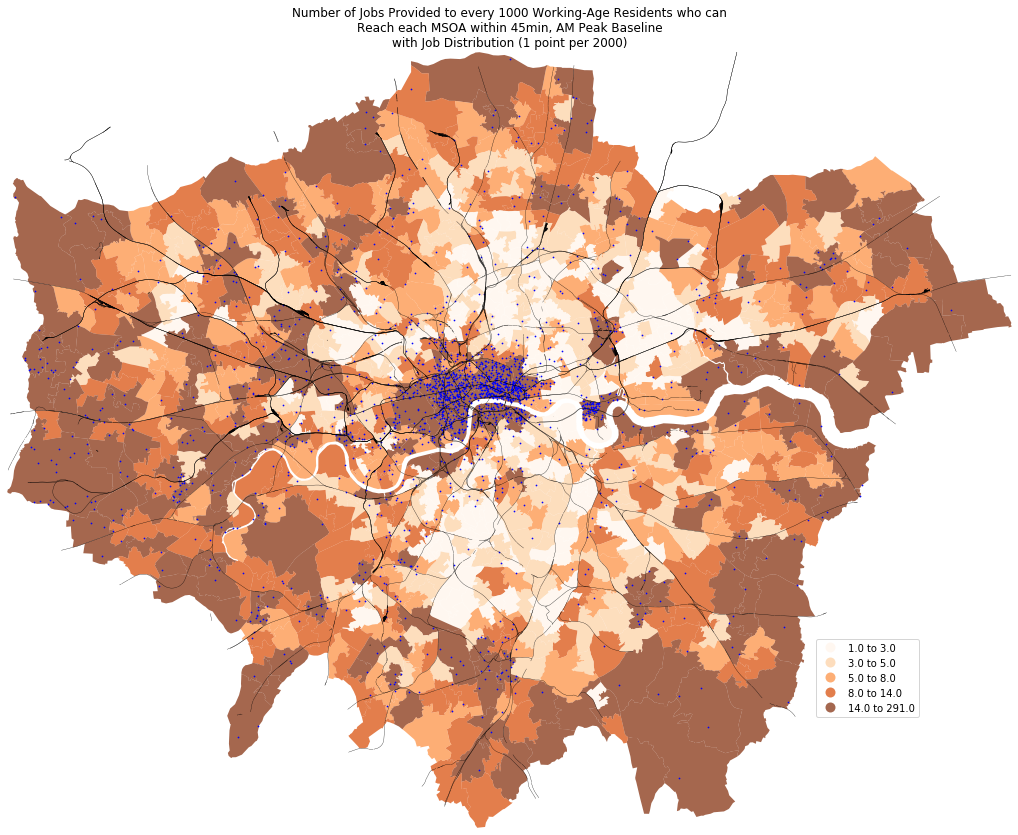

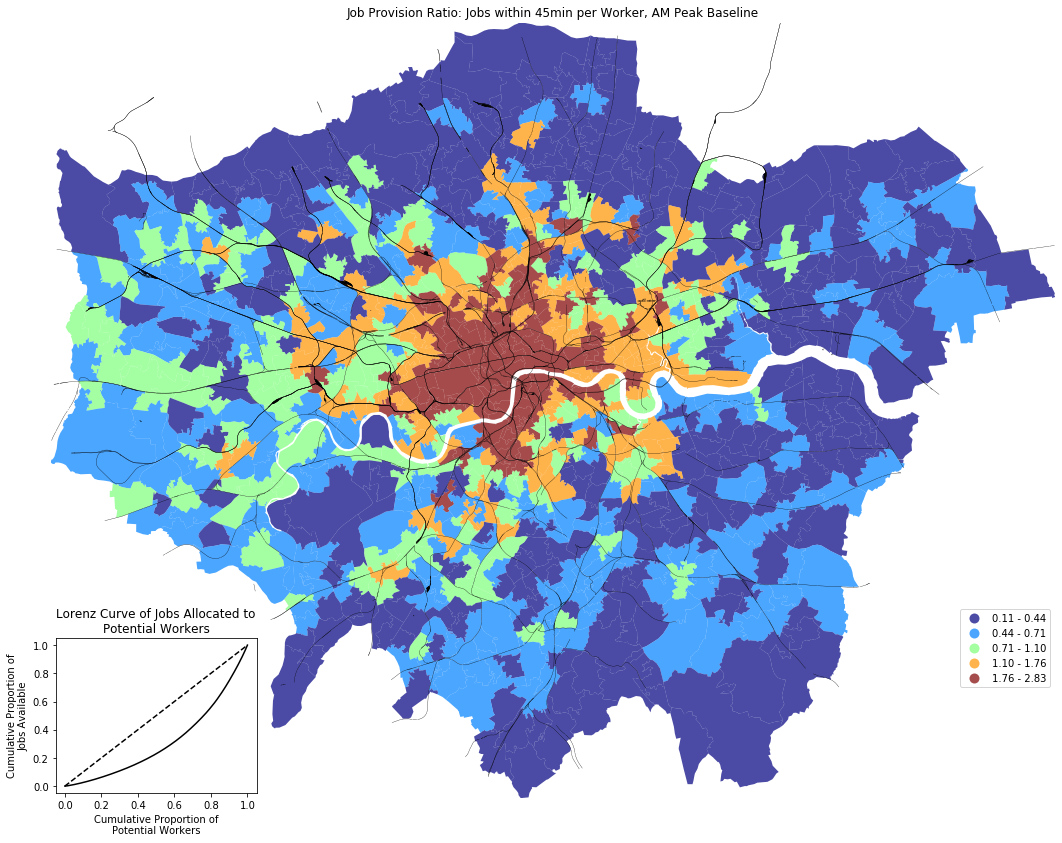

In [89]:
# plot map
mean_jobs_per_workingagepop = jpr_ampeak_baseline['Jobs_Total'].sum() / jpr_ampeak_baseline['Pop_WorkingAge'].sum()
print('Mean Jobs per Working Age Pop:', mean_jobs_per_workingagepop)

fig05_01 = plt.figure(figsize = (18,16))
ax05_01 = fig05_01.add_subplot(1,1,1)
set_zoom(ax05_01, msoas)
k05_01 = 5
jpr_ampeak_baseline.plot(column = 'Users Who Can Access', ax = ax05_01, scheme = 'quantiles', k = k05_01, legend = True, cmap = 'Blues')
poppoints.plot(color = 'Red', ax = ax05_01, markersize = .5)
#set legend labels
legend05_01 = ax05_01.get_legend()
quantiles05_01 = np.quantile(jpr_ampeak_baseline['Users Who Can Access'], [1 / k05_01 * i for i in range(k05_01 + 1)])
for i in range(len(legend05_01.get_texts())):
    legend05_01.get_texts()[i].set_text(str(round(quantiles05_01[i] / 1000,0)) + ' to ' + str(round(quantiles05_01[i+1] / 1000, 0)))
londontube.plot(color = 'black', ax = ax05_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax05_01, linewidth = .3)
plt.title('Number of Working-Age Residents (1000s) who can Reach each MSOA\nwithin 45min, AM Peak Baseline\nwith Population Distribution (1 point per 2000)')
legend05_01.set_bbox_to_anchor((.8,.25))
plt.axis('off')
    
fig05_02 = plt.figure(figsize = (18,16))
ax05_02 = fig05_02.add_subplot(1,1,1)
set_zoom(ax05_02, msoas)
k05_02 = 5
jpr_ampeak_baseline.plot(column = 'Targets per User Who Can Access', ax = ax05_02, scheme = 'quantiles', k = k05_02, legend = True, cmap = 'Oranges', alpha = .7)
jobpoints.plot(color = 'Blue', ax = ax05_02, markersize = .5)
#set legend labels
legend05_02 = ax05_02.get_legend()
quantiles05_02 = np.quantile(jpr_ampeak_baseline['Targets per User Who Can Access'], [1 / k05_01 * i for i in range(k05_01 + 1)])
for i in range(len(legend05_02.get_texts())):
    legend05_02.get_texts()[i].set_text(str(round(quantiles05_02[i] * 1000,0)) + ' to ' + str(round(quantiles05_02[i+1] * 1000, 0)))
londontube.plot(color = 'black', ax = ax05_02, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax05_02, linewidth = .3)
plt.title('Number of Jobs Provided to every 1000 Working-Age Residents who can\nReach each MSOA within 45min, AM Peak Baseline\nwith Job Distribution (1 point per 2000)')
legend05_02.set_bbox_to_anchor((.8,.25))
plt.axis('off')

fig05_03 = plt.figure(figsize = (18,16))
ax05_03 = fig05_03.add_subplot(1,1,1)
set_zoom(ax05_03, msoas)
jpr_ampeak_baseline.plot(column = 'Targets within ' + str(traveltime_cutoff) + 'min per User', ax = ax05_03, 
                         scheme = 'userdefined', 
                         classification_kwds = {'bins': [i * mean_jobs_per_workingagepop for i in [.5,.8,1.25,2]]}, # set breaks to 50%, 80%, 125% and 200% of mean jobs to pop ratio
                         cmap = 'jet', legend = True, alpha = .7)
londontube.plot(color = 'black', ax = ax05_03, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax05_03, linewidth = .3)
plt.title('Job Provision Ratio: Jobs within ' + str(traveltime_cutoff) + 'min per Worker, AM Peak Baseline')
legend05_03 = ax05_03.get_legend()
legend05_03.set_bbox_to_anchor((1,.25))
plt.axis('off')

# plot Lorenz curve
lorenz_jobsalloc = jpr_ampeak_baseline.sort_values(by = 'Targets within ' + str(traveltime_cutoff) + 'min per User').loc[:,['Pop_WorkingAge', 'Targets Allocated to Users']].cumsum()
ax05_04 = inset_axes(ax05_03, width = '20%', height = '20%', loc = 3)
plt.plot(lorenz_jobsalloc['Pop_WorkingAge']/np.sum(jpr_ampeak_baseline['Pop_WorkingAge']), lorenz_jobsalloc['Targets Allocated to Users']/np.sum(jpr_ampeak_baseline['Targets Allocated to Users']), color = 'black')
ax05_04.plot([0,1], [0,1], 'k--') # plot 1:1 line
ax05_04.set_xlabel('Cumulative Proportion of\nPotential Workers')
ax05_04.set_ylabel('Cumulative Proportion of\nJobs Available')
plt.title('Lorenz Curve of Jobs Allocated to\nPotential Workers')

### Fig XX: Lorenz Curves and Gini Coefficients for Job Allocations

All jobs aggregated correctly to larger sectors: True


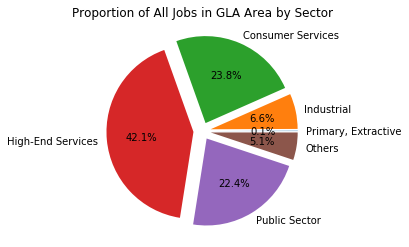

In [76]:
# aggregate 21 industrial sectors to 6 overarching sectors
jobcounts_aggregated_sectors = pd.DataFrame(index = jobcounts.index)
jobcounts_aggregated_sectors['Primary, Extractive'] = np.sum(jobcounts[['Jobs_Agriculture', 'Jobs_Mining']], axis = 1)
jobcounts_aggregated_sectors['Industrial'] = np.sum(jobcounts[['Jobs_Manufacturing',
       'Jobs_Energy_Utilities', 'Jobs_Water_Utilities', 'Jobs_Construction',]], axis = 1)
jobcounts_aggregated_sectors['Consumer Services'] = np.sum(jobcounts[['Jobs_Wholesale_Retail', 'Jobs_Transport_Storage', 
       'Jobs_Accom_Food']], axis = 1)
jobcounts_aggregated_sectors['High-End Services'] = np.sum(jobcounts[['Jobs_Infocomm', 'Jobs_Finance_Insurance', 'Jobs_Real_Estate',
       'Jobs_Professional_Scientific_Technical', 'Jobs_Administrative_Support']], axis = 1)
jobcounts_aggregated_sectors['Public Sector'] = np.sum(jobcounts[['Jobs_Public_Admin_Defence', 'Jobs_Education',
       'Jobs_Health_Social_Work']], axis = 1)
jobcounts_aggregated_sectors['Others'] = np.sum(jobcounts[['Jobs_Arts_Entertainment',
       'Jobs_Other_Services', 'Jobs_Household', 'Jobs_Extraterrestrial_Orgs']], axis = 1)

plt.pie(jobcounts_aggregated_sectors.sum(), labels = jobcounts_aggregated_sectors.columns, autopct='%1.1f%%', explode = [.1 for i in jobcounts_aggregated_sectors.columns])
plt.title('Proportion of All Jobs in GLA Area by Sector')
# check that aggregation did not miss out any jobs
print('All jobs aggregated correctly to larger sectors:', np.sum(np.sum(jobcounts_aggregated_sectors)) == np.sum(jobcounts['Jobs_Total']))

Text(0.5, 1.0, 'Proportion of All Jobs in GLA Area by Sector')

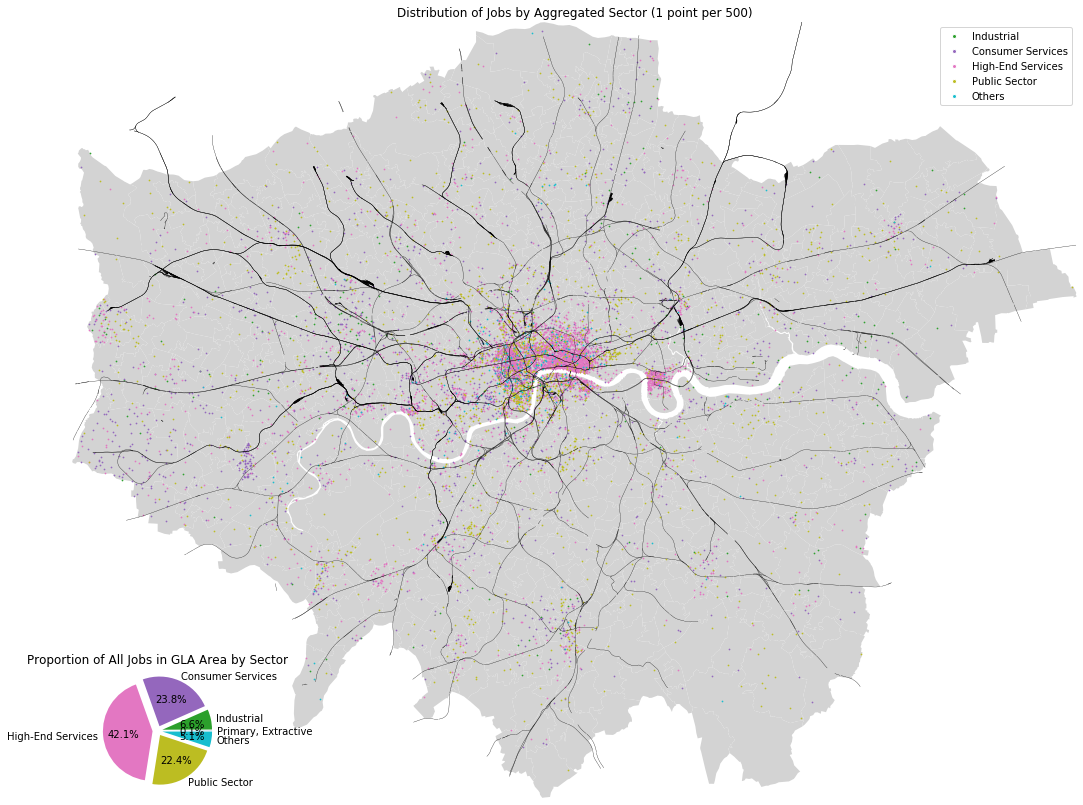

In [91]:
# set colormaps
colormap = []
colors = plt.cm.tab10(np.linspace(0, 1, len(jobcounts_aggregated_sectors.columns))) # generate colours used in mapping
for c in colors: # convert colours to hex format
    colormap.append(matplotlib.colors.to_hex(c))
    
count_per_point = 500
fig12 = plt.figure(figsize = (18,16))
ax12_01 = fig12.add_subplot(111)
set_zoom(ax12_01, msoas)
msoas.plot(ax = ax12_01, color = 'lightgrey')
i = 1 # exclude primary, extractive jobs as there are too few to visualise
for sector in jobcounts_aggregated_sectors.columns[1:]: # exclude primary, extractive jobs as there are too few to visualise
    # generate dot density map
    jobpoints_sector = gpd.GeoDataFrame(gen_points_in_gdf_polys(msoas.geometry, jobcounts_aggregated_sectors[sector], points_per_value = count_per_point))
    jobpoints_sector.plot(markersize = .5, ax = ax12_01, color = colormap[i])
    i += 1

londontube.plot(color = 'black', ax = ax12_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax12_01, linewidth = .3)
plt.title('Distribution of Jobs by Aggregated Sector (1 point per ' + str(count_per_point) + ')')
plt.axis('off')
legend12_01_elements = [matplotlib.lines.Line2D([0], [0], marker='o', color='w', label = jobcounts_aggregated_sectors.columns[i],
                                                markerfacecolor = colormap[i], markersize = 4) 
                        for i in range(1,len(jobcounts_aggregated_sectors.columns))]
ax12_01.legend(handles = legend12_01_elements, loc = 'upper right')

ax12_02 = inset_axes(ax12_01, width = '16%', height = '16%', loc = 3)
plt.pie(jobcounts_aggregated_sectors.sum(), labels = jobcounts_aggregated_sectors.columns, autopct='%1.1f%%', explode = [.1 for i in jobcounts_aggregated_sectors.columns], colors = colormap)
plt.title('Proportion of All Jobs in GLA Area by Sector')

In [78]:
jpr_sectoral_ampeak_baseline = {sector: None for sector in jobcounts_aggregated_sectors.columns}
for sector in jpr_sectoral_ampeak_baseline.keys():
    jpr_sectoral_ampeak_baseline[sector] = calculate_provision_ratios(popcounts[['Pop_WorkingAge']], jobcounts_aggregated_sectors[[sector]], ttm_baseline_ampeak, traveltime_cutoff)
    jpr_sectoral_ampeak_baseline[sector] = msoas.join(jpr_sectoral_ampeak_baseline[sector])

All targets allocated exactly once to reachable users: Primary, Extractive    True
dtype: bool
All targets allocated exactly once to reachable users: Industrial    True
dtype: bool
All targets allocated exactly once to reachable users: Consumer Services    True
dtype: bool
All targets allocated exactly once to reachable users: High-End Services    True
dtype: bool
All targets allocated exactly once to reachable users: Public Sector    True
dtype: bool
All targets allocated exactly once to reachable users: Others    True
dtype: bool


Mean Primary, Extractive Jobs per Potential Worker: 0.0005616916578994774
Mean Industrial Jobs per Potential Worker: 0.05785842624544871
Mean Consumer Services Jobs per Potential Worker: 0.21021666062841157
Mean High-End Services Jobs per Potential Worker: 0.3710730972632306
Mean Public Sector Jobs per Potential Worker: 0.19740657502358938
Mean Others Jobs per Potential Worker: 0.04506424547147611


Text(0.5, 1.0, 'Lorenz Curves of Jobs Available to Potential Workers by Sector')

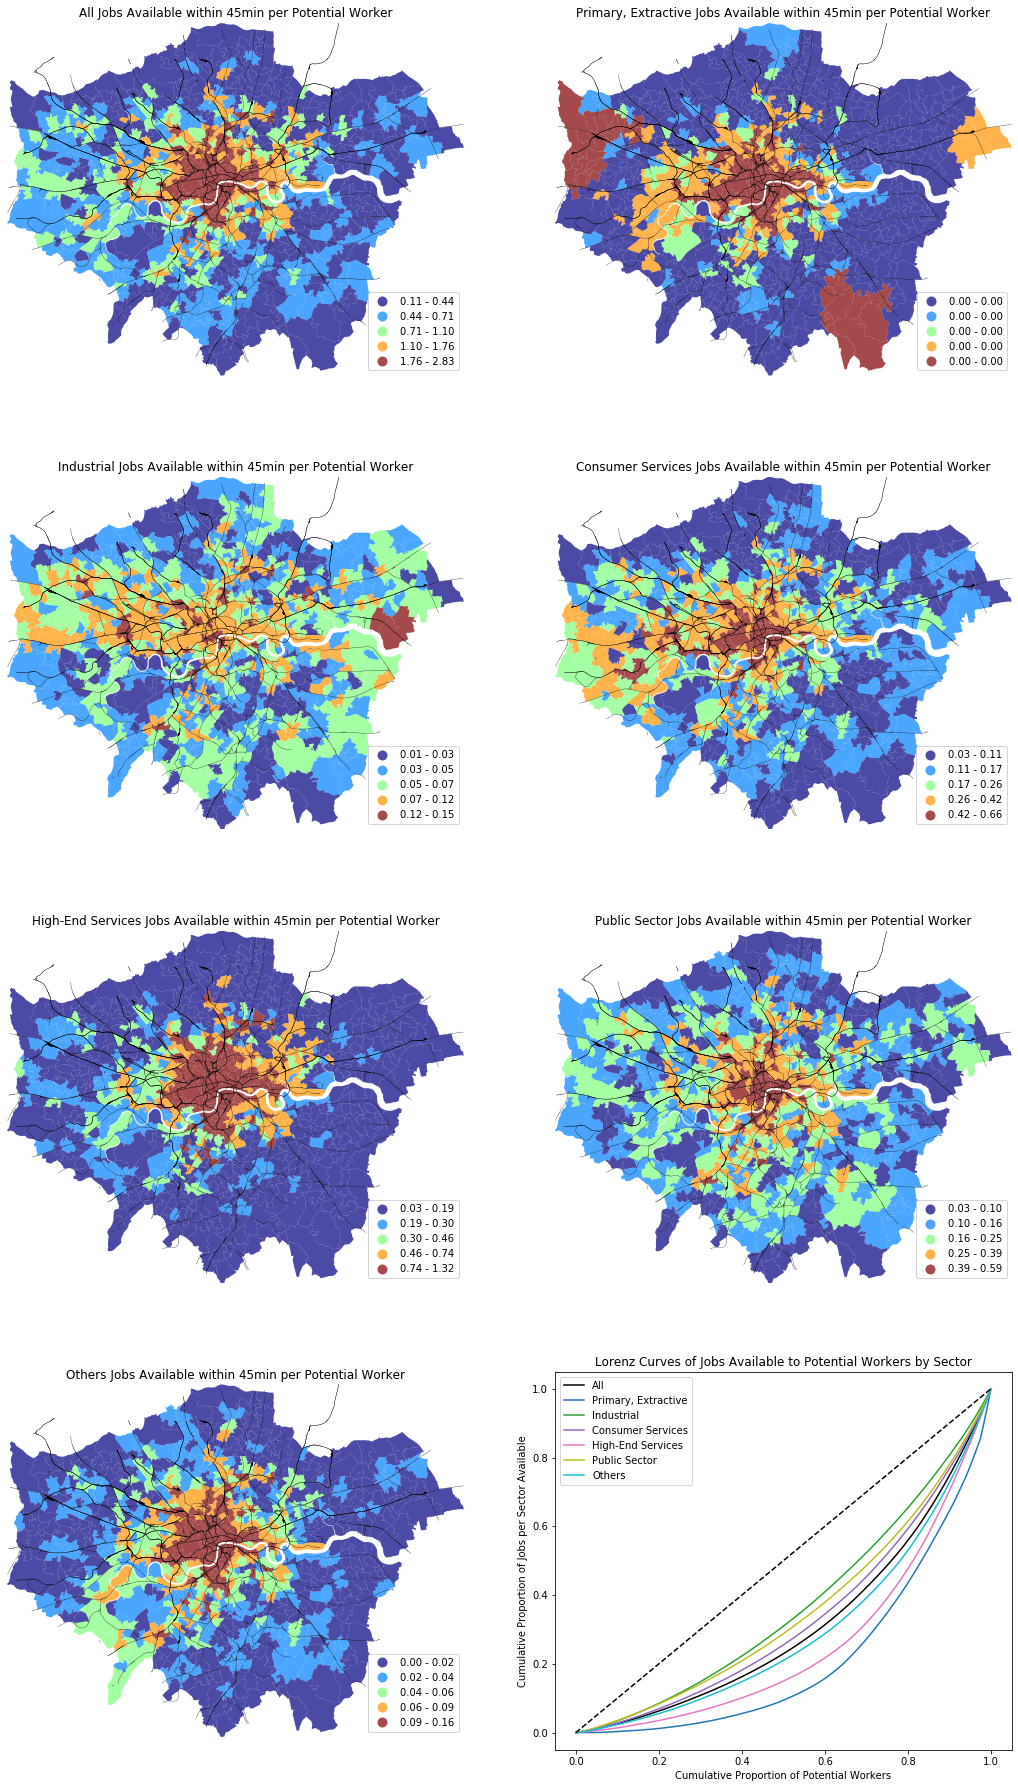

In [94]:
fig10 = plt.figure(figsize = (18, 32))
ax10_01 = fig10.add_subplot(4,2,1)
set_zoom(ax10_01, msoas)
mean_jobs_per_workingagepop = jpr_ampeak_baseline['Jobs_Total'].sum() / jpr_ampeak_baseline['Pop_WorkingAge'].sum()
jpr_ampeak_baseline.plot(column = 'Targets within ' + str(traveltime_cutoff) + 'min per User', ax = ax10_01, 
                         scheme = 'userdefined', 
                         classification_kwds = {'bins':[i * mean_jobs_per_workingagepop for i in [.5,.8,1.25,2]]}, # set breaks to 50%, 80%, 125% and 200% of mean jobs to pop ratio
                         cmap = 'jet', legend = True, alpha = .7)
londontube.plot(color = 'black', ax = ax10_01, linewidth = .3) # rail lines
londonrail.plot(color = 'black', ax = ax10_01, linewidth = .3)
plt.title('All Jobs Available within ' + str(traveltime_cutoff) + 'min per Potential Worker')
legend10_01 = ax10_01.get_legend()
legend10_01.set_bbox_to_anchor((1,.25))
plt.axis('off')

j = 2
for sector in jpr_sectoral_ampeak_baseline.keys():
    ax10 = fig10.add_subplot(4,2,j)
    set_zoom(ax10, msoas)
    mean_jobs_per_workingagepop = jpr_sectoral_ampeak_baseline[sector][sector].sum() / jpr_sectoral_ampeak_baseline[sector]['Pop_WorkingAge'].sum()
    print('Mean', sector, 'Jobs per Potential Worker:', mean_jobs_per_workingagepop)
    jpr_sectoral_ampeak_baseline[sector].plot(column = 'Targets within ' + str(traveltime_cutoff) + 'min per User', ax = ax10, 
                                              scheme = 'userdefined', 
                                              classification_kwds = {'bins':[i * mean_jobs_per_workingagepop for i in [.5,.8,1.25,2]]}, # set breaks to 50%, 80%, 125% and 200% of mean jobs to pop ratio
                                              cmap = 'jet', legend = True, alpha = .7)
    londontube.plot(color = 'black', ax = ax10, linewidth = .3) # rail lines
    londonrail.plot(color = 'black', ax = ax10, linewidth = .3)
    plt.title(sector + ' Jobs Available within ' + str(traveltime_cutoff) + 'min per Potential Worker')
    legend10 = ax10.get_legend()
    legend10.set_bbox_to_anchor((1,.25))
    plt.axis('off')
    j += 1

ax10_08 = fig10.add_subplot(4,2,8)
plt.plot(lorenz_jobsalloc['Pop_WorkingAge']/np.sum(jpr_ampeak_baseline['Pop_WorkingAge']), lorenz_jobsalloc['Targets Allocated to Users']/np.sum(jpr_ampeak_baseline['Targets Allocated to Users']), 'k-', label = 'All')
i = 0
for sector in jpr_sectoral_ampeak_baseline.keys():
    lorenz_jobsalloc_sectoral = jpr_sectoral_ampeak_baseline[sector].sort_values(by = 'Targets within ' + str(traveltime_cutoff) + 'min per User').loc[:,['Pop_WorkingAge', 'Targets Allocated to Users']].cumsum()
    plt.plot(lorenz_jobsalloc_sectoral['Pop_WorkingAge']/np.sum(jpr_sectoral_ampeak_baseline[sector]['Pop_WorkingAge']), lorenz_jobsalloc_sectoral['Targets Allocated to Users']/np.sum(jpr_sectoral_ampeak_baseline[sector]['Targets Allocated to Users']), label = sector, color = colormap[i])
    i += 1
ax10_08.plot([0,1], [0,1], 'k--') # plot 1:1 line
plt.legend()
ax10_08.set_xlabel('Cumulative Proportion of Potential Workers')
ax10_08.set_ylabel('Cumulative Proportion of Jobs per Sector Available')
plt.title('Lorenz Curves of Jobs Available to Potential Workers by Sector')

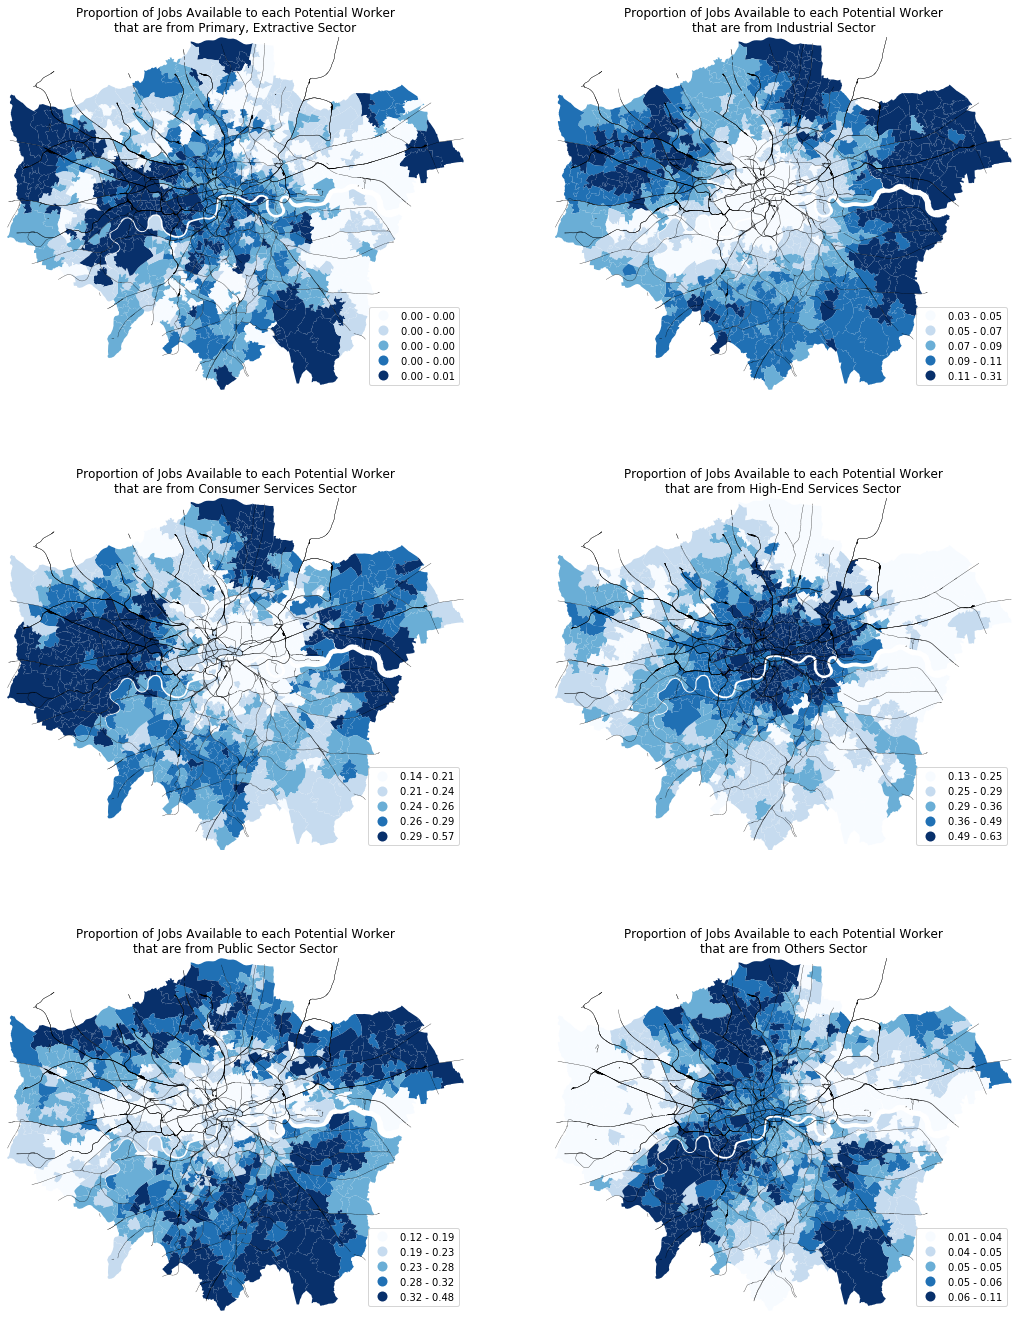

In [96]:
fig11 = plt.figure(figsize = (18, 24))
j = 1
for sector in jpr_sectoral_ampeak_baseline.keys():
    ax11 = fig11.add_subplot(3,2,j)
    set_zoom(ax11, msoas)
    jpr_sectoral_ampeak_baseline[sector]['PC Allocation From Sector'] = jpr_sectoral_ampeak_baseline[sector]['Targets within ' + str(traveltime_cutoff) + 'min per User'] / jpr_ampeak_baseline['Targets within ' + str(traveltime_cutoff) + 'min per User']
    jpr_sectoral_ampeak_baseline[sector].plot(column = 'PC Allocation From Sector', ax = ax11, 
                                              scheme = 'quantiles', 
                                              k = 5,
                                              cmap = 'Blues', legend = True)
    londontube.plot(color = 'black', ax = ax11, linewidth = .3) # rail lines
    londonrail.plot(color = 'black', ax = ax11, linewidth = .3)
    plt.title('Proportion of Jobs Available to each Potential Worker\nthat are from ' + sector + ' Sector')
    legend11 = ax11.get_legend()
    legend11.set_bbox_to_anchor((1,.25))
    plt.axis('off')
    j += 1

### KMeans Clustering of MSOAs by IMD and Job Allocation by Sector

In [81]:
with open('../90 Data/compiled secondary data/imd_msoa', 'rb') as infile:
    imd_msoa = pickle.load(infile)
imd_msoa = imd_msoa.loc[msoas.index,:]

In [82]:
# KMeans clustering for IMD, JPR and reliance on 4 sectors
kmeans_data = jpr_ampeak_baseline[['Targets within ' + str(traveltime_cutoff) + 'min per User']]
for sector in jobcounts_aggregated_sectors.columns[1:5]:
    kmeans_data = kmeans_data.join(jpr_sectoral_ampeak_baseline[sector]['PC Allocation From Sector'])
    kmeans_data.rename({'PC Allocation From Sector': sector}, axis = 1, inplace = True)
kmeans_data = kmeans_data.join(imd_msoa[['Index of Multiple Deprivation (IMD) Rank']])
# create version of data with columns standardised for KMeans clustering
kmeans_data_standardised = pd.DataFrame(StandardScaler().fit_transform(X = kmeans_data), columns = kmeans_data.columns, index = kmeans_data.index)

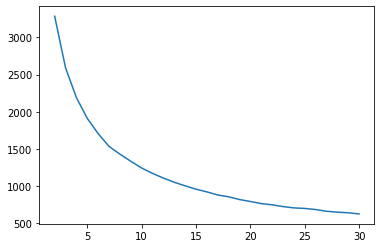

In [83]:
# identify suitable value for k
n_clusters = [i+2 for i in range(29)]
inertias = []
for i in n_clusters:
    inertias.append(KMeans(i, random_state = 1000).fit(kmeans_data_standardised).inertia_)
plt.plot(n_clusters, inertias)

In [84]:
# carry out KMeans clustering
n_clusters = 7
kmeans1 = KMeans(n_clusters, random_state = 6881).fit(kmeans_data_standardised)
# join clustering labels to raw data
kmeans_data['kmeans_cluster_' + str(n_clusters)] = kmeans1.labels_

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

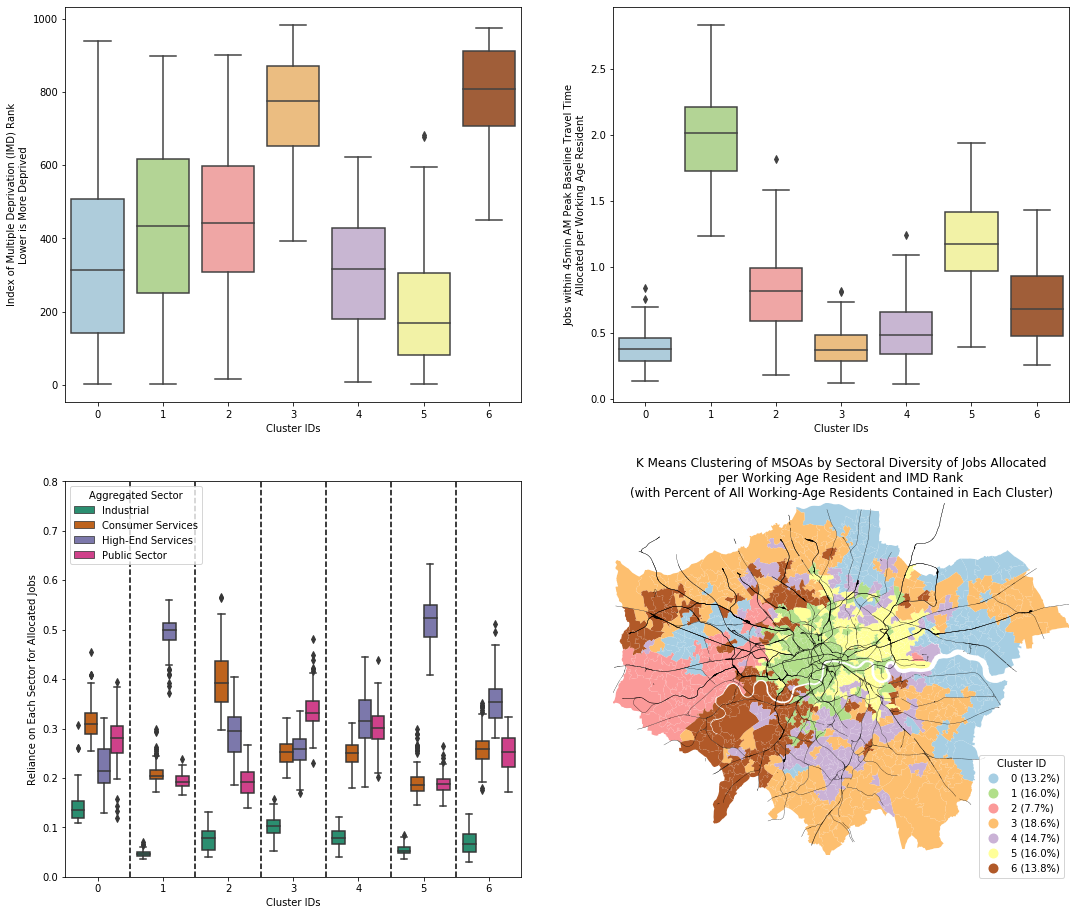

In [85]:
# set colormaps
colormap = []
colors = plt.cm.Paired(np.linspace(0, 1, n_clusters)) # generate colours used in mapping
for c in colors: # convert colours to hex format
    colormap.append(matplotlib.colors.to_hex(c))

# calculate percent working-age pop in each cluster
pop_per_cluster = jpr_ampeak_baseline[['Pop_WorkingAge']].join(kmeans_data['kmeans_cluster_' + str(n_clusters)])
pop_per_cluster = pop_per_cluster.groupby('kmeans_cluster_' + str(n_clusters)).sum() / jpr_ampeak_baseline['Pop_WorkingAge'].sum()

# plot data
fig09 = plt.figure(figsize = (18,16))

# boxplot of IMD ranks per cluster
ax09_01 = fig09.add_subplot(2,2,1)
with sns.color_palette(colormap):
    ax09_01 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Index of Multiple Deprivation (IMD) Rank', data = kmeans_data)
ax09_01.set_xlabel('Cluster IDs')
ax09_01.set_ylabel('Index of Multiple Deprivation (IMD) Rank\nLower is More Deprived')

# boxplot of JPR value distributions per cluster
ax09_02 = fig09.add_subplot(2,2,2)
with sns.color_palette(colormap):
    ax09_02 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'Targets within 45min per User', data = kmeans_data)
ax09_02.set_xlabel('Cluster IDs')
ax09_02.set_ylabel('Jobs within 45min AM Peak Baseline Travel Time\nAllocated per Working Age Resident')

# boxplot of sectoral reliance per cluster
ax09_03 = fig09.add_subplot(2,2,3)
kmeans_data2 = pd.melt(kmeans_data[list(kmeans_data.columns[1:5])].reset_index(), id_vars = 'MSOA', value_vars = list(kmeans_data.columns[1:5]))
kmeans_data2 = kmeans_data2.merge(kmeans_data[['kmeans_cluster_' + str(n_clusters)]], left_on = 'MSOA', right_index = True)
with sns.color_palette('Dark2'):
    ax09_03 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = 'value', hue = 'variable', data = kmeans_data2)
ax09_03.set_ylim((0,.8))
for i in range(n_clusters - 1):
    ax09_03.axvline((i + .5), color = 'black', linestyle = '--')
ax09_03.set_xlabel('Cluster IDs')
ax09_03.set_ylabel('Reliance on Each Sector for Allocated Jobs')
legend09_03 = ax09_03.get_legend()
legend09_03.set_title('Aggregated Sector')

# clustering map
ax09_04 = fig09.add_subplot(2,2,4)
set_zoom(ax09_04, msoas)
msoas.join(kmeans_data).plot(column = 'kmeans_cluster_' + str(n_clusters), ax = ax09_04, cmap = 'Paired', categorical = True, legend = True)
londontube.plot(color = 'black', linewidth = .3, ax = ax09_04)
londonrail.plot(color = 'black', linewidth = .3, ax = ax09_04)
legend09_04 = ax09_04.get_legend()
legend09_04.set_bbox_to_anchor((1,.3))
legend09_04.set_title('Cluster ID')
for i in range(len(legend09_04.get_texts())):
    legend09_04.get_texts()[i].set_text(str(i) + ' (' + str(round(pop_per_cluster.at[i,'Pop_WorkingAge'] * 100, 1)) + '%)')
plt.title('K Means Clustering of MSOAs by Sectoral Diversity of Jobs Allocated\nper Working Age Resident and IMD Rank\n(with Percent of All Working-Age Residents Contained in Each Cluster)')
plt.axis('off')

### Write Out Useful Datasets

In [86]:
prepped_data = {'jpr_ampeak_baseline': jpr_ampeak_baseline,
                'jpr_sectoral_ampeak_baseline': jpr_sectoral_ampeak_baseline,
                'jobcounts_aggregated_sectors': jobcounts_aggregated_sectors}

for dataset in prepped_data.keys():
    with open('../90 Data/compiled secondary data/' + dataset, 'wb') as outfile:
        pickle.dump(prepped_data[dataset], outfile)